In [99]:
# Utils
import os, sys, re, time, gc, types, string, unicodedata, unidecode, string, warnings, inspect

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import time
import pickle

from sklearn.metrics import accuracy_score
from IPython.display import display, Markdown, Latex

import shutil

from tensorflow.contrib.learn import DNNClassifier
import scikitplot as skplt

import scipy
#plt.style.use('fivethirtyeight')

# Parameters

In [100]:
root_path = "../"
path_model = root_path + 'models/testV2'
#features_path = root_path + 'data/features/data_tfid_hash28_n1000_SVD2.p'
#features_path = root_path + 'data/features/data_tfid_hash28_n10000_bigram_svd1000.p'
#features_path = root_path + 'data/features/data_tfid_hash28_n1000.p'

features_path = root_path + 'data/features/dataV2_tfid_hash28_n10000_svd1000_sin_stemmig.p'



# Load Data

### Output

In [101]:
X ,y1 ,y2 , y3 = pickle.load( open( features_path, "rb" ) )


In [102]:
train_fraction = 0.90

y1 = y1.values    

np.random.seed(42)
train_indices = np.random.choice(X.shape[0], round(train_fraction*X.shape[0]), replace=False)
test_indices = np.array(list(set(range(X.shape[0])) - set(train_indices)))

X_train = X[train_indices]
y_train = y1[train_indices]
X_test = X[test_indices]
y_test = y1[test_indices]

In [103]:
labels = list(set(y_train))
labels.sort()
nClasses = len(labels)

def calcWeights(y):
    sizes = {label: y_train[y_train == label].shape[0] for label in labels}
    weights = np.asarray([float(len(y_train))/(sizes[label]*nClasses) for label in y]) #n_samples / (n_classes * np.bincount(y))
    weights = np.power(weights,1) # 1.4
    return weights 

def calcWeightsL(y):
    #lerko
    scale_factor = 10e3
    sizes = {label: y_train[y_train == label].shape[0] for label in labels}
    weights = np.asarray([scale_factor/sizes[label] for label in y])
    return weights 

weights_train = calcWeights(y_train)
weights_test = calcWeights(y_test)

# Model

### DNN graph generation

In [104]:
epochs = 20000

if isinstance(X_train, scipy.sparse.csr.csr_matrix):
    X_train = X_train.todense()
    X_test = X_test.todense()

# Define the test inputs
def get_train_inputs():    
    dataset = tf.estimator.inputs.numpy_input_fn({'x': X_train,'class_weights': weights_train},
                                                  y_train[:,np.newaxis],
                                                  shuffle=True,
                                                  batch_size=500,
                                                  num_epochs=epochs)
    return dataset

def get_test_inputs():
    dataset = tf.estimator.inputs.numpy_input_fn({'x': X_test,'class_weights': weights_test},
                                                  y_test[:,np.newaxis],
                                                  shuffle=False)
    return dataset

### functions graph tensorflow

In [105]:



feature_columns = [tf.contrib.layers.real_valued_column('x', dimension=X_train.shape[1])]

optimizer = tf.train.ProximalAdagradOptimizer(
                              learning_rate=10.0,
                              l1_regularization_strength= 0.0#0.0001
                              )

classifier = DNNClassifier(                                
                           n_classes=len(labels), label_keys=labels, feature_columns=feature_columns,
                           hidden_units=[2000,1000], #2000, 1000, 100
                           dropout=0.5,
                           #optimizer = optimizer,
                           weight_column_name='class_weights',
                           model_dir = path_model,
                           config = tf.contrib.learn.RunConfig(save_checkpoints_steps = 500,
                           save_checkpoints_secs = None)                           
                          )

INFO:tensorflow:Using config: {'_device_fn': None, '_save_summary_steps': 100, '_keep_checkpoint_max': 5, '_save_checkpoints_steps': 500, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_task_type': None, '_environment': 'local', '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '../models/testV2', '_log_step_count_steps': 100, '_task_id': 0, '_evaluation_master': '', '_is_chief': True, '_session_config': None, '_master': '', '_tf_random_seed': None, '_save_checkpoints_secs': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f69f3920358>, '_num_worker_replicas': 0, '_train_distribute': None}


# Training



In [106]:
tf.set_random_seed(42)

delete_old_model = True
if delete_old_model:
    try:
        os.system("rm -rf "+path_model)
        os.system("mkdir "+path_model)
    except:
        print("error")
    
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    #input_fn= get_train_inputs(),
    input_fn= get_test_inputs(),
    
    every_n_steps=500,
    #early_stopping_metric="accuracy",   #accurray mucho mas rapido,7s vs 40s, pero 2% peor
    early_stopping_metric="loss",   
    early_stopping_metric_minimize=True,
    early_stopping_rounds=2500)

start = time.time()
print("start")

#classifier.fit(input_fn=get_train_inputs(), monitors=[validation_monitor], steps=epochs, max_steps=None)
classifier.fit(input_fn=get_train_inputs(), monitors=[validation_monitor], steps=epochs, max_steps=None)

end = time.time()
print("Training time :" + str(end - start) )


start
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ../models/testV2/model.ckpt.
INFO:tensorflow:loss = 2.1638355, step = 0
INFO:tensorflow:global_step/sec: 131.846
INFO:tensorflow:loss = 1.9963962, step = 100 (0.759 sec)
INFO:tensorflow:global_step/sec: 151.748
INFO:tensorflow:loss = 2.2254581, step = 200 (0.659 sec)
INFO:tensorflow:global_step/sec: 152.331
INFO:tensorflow:loss = 1.8818616, step = 300 (0.656 sec)
INFO:tensorflow:global_step/sec: 152.025
INFO:tensorflow:loss = 1.1873302, step = 400 (0.658 sec)
INFO:tensorflow:Saving checkpoints for 500 into ../models/testV2/model.ckpt.
INFO:tensorflow:global_step/sec: 139.538
INFO:tensorflow:Starting evaluation at 2018-12-18-13:00:18
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/testV2/model.ckpt-500
INFO:tensorflow:Running local_in

INFO:tensorflow:Finished evaluation at 2018-12-18-13:00:49
INFO:tensorflow:Saving dict for global step 4500: accuracy = 0.8405457, global_step = 4500, loss = 0.46492904
INFO:tensorflow:Validation (step 4500): accuracy = 0.8405457, global_step = 4500, loss = 0.46492904
INFO:tensorflow:loss = 0.5037733, step = 4500 (1.521 sec)
INFO:tensorflow:global_step/sec: 68.0749
INFO:tensorflow:loss = 0.40074673, step = 4600 (0.656 sec)
INFO:tensorflow:global_step/sec: 152.836
INFO:tensorflow:loss = 0.41945297, step = 4700 (0.654 sec)
INFO:tensorflow:global_step/sec: 152.3
INFO:tensorflow:loss = 0.48015013, step = 4800 (0.657 sec)
INFO:tensorflow:global_step/sec: 152.424
INFO:tensorflow:loss = 0.38082954, step = 4900 (0.656 sec)
INFO:tensorflow:Saving checkpoints for 5000 into ../models/testV2/model.ckpt.
INFO:tensorflow:global_step/sec: 139.542
INFO:tensorflow:loss = 0.5696313, step = 5000 (0.717 sec)
INFO:tensorflow:global_step/sec: 152.268
INFO:tensorflow:loss = 0.5135568, step = 5100 (0.656 sec)

INFO:tensorflow:global_step/sec: 152.477
INFO:tensorflow:loss = 0.44538137, step = 9400 (0.656 sec)
INFO:tensorflow:Saving checkpoints for 9500 into ../models/testV2/model.ckpt.
INFO:tensorflow:global_step/sec: 140.689
INFO:tensorflow:Starting evaluation at 2018-12-18-13:01:26
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/testV2/model.ckpt-9500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-18-13:01:27
INFO:tensorflow:Saving dict for global step 9500: accuracy = 0.8444006, global_step = 9500, loss = 0.45222053
INFO:tensorflow:Validation (step 9500): accuracy = 0.8444006, global_step = 9500, loss = 0.45222053
INFO:tensorflow:loss = 0.42597613, step = 9500 (1.515 sec)
INFO:tensorflow:global_step/sec: 68.6337
INFO:tensorflow:loss = 0.46545923, step = 9600 (0.652 sec)
INFO:tensorflow:global_step/sec: 153.656
INFO:tensorflow:loss = 0.38839018, step = 9700 (0.651 sec)

INFO:tensorflow:loss = 0.2676553, step = 13800 (0.653 sec)
INFO:tensorflow:global_step/sec: 152.924
INFO:tensorflow:loss = 0.26405922, step = 13900 (0.654 sec)
INFO:tensorflow:Saving checkpoints for 14000 into ../models/testV2/model.ckpt.
INFO:tensorflow:global_step/sec: 141.37
INFO:tensorflow:loss = 0.18601848, step = 14000 (0.707 sec)
INFO:tensorflow:global_step/sec: 151.901
INFO:tensorflow:loss = 0.288609, step = 14100 (0.658 sec)
INFO:tensorflow:global_step/sec: 150.5
INFO:tensorflow:loss = 0.2651438, step = 14200 (0.664 sec)
INFO:tensorflow:global_step/sec: 153.011
INFO:tensorflow:loss = 0.30257812, step = 14300 (0.654 sec)
INFO:tensorflow:global_step/sec: 152.405
INFO:tensorflow:loss = 0.32026774, step = 14400 (0.656 sec)
INFO:tensorflow:Saving checkpoints for 14500 into ../models/testV2/model.ckpt.
INFO:tensorflow:global_step/sec: 141.797
INFO:tensorflow:Starting evaluation at 2018-12-18-13:02:03
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../m

# Evaluation performance


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/testV2/model.ckpt-14501
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


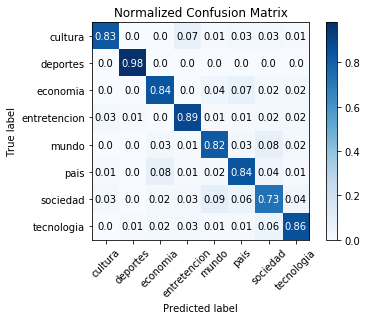

## Accuracy in test: 88.9802304081923 

In [107]:
#X_test = X_test.todense().p'

def input_fn_evaluate():
    dataset = {'x': tf.constant(X_test )}    
    return dataset

pred_test = classifier.predict_classes(input_fn=input_fn_evaluate)
y_test_hat = np.asarray([x.decode('UTF-8') for x in list(pred_test)])
y_test_hat = y_test_hat.astype(str)


acc = accuracy_score(y_true=y_test, y_pred=y_test_hat)

skplt.metrics.plot_confusion_matrix(y_test, y_test_hat,normalize='True')
plt.xticks(rotation=45)
plt.show()

#print('Accuracy in test: {}'.format(acc))
display(Markdown('## Accuracy in test: {} '.format(acc*100)))

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/testV2/model.ckpt-14501
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


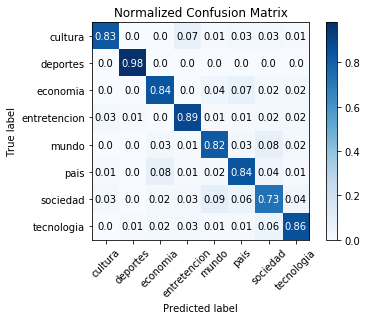

## Accuracy in test: 88.9802304081923 

In [108]:
#X_test = X_test.todense()

def input_fn_evaluate():
    dataset = {'x': tf.constant(X_test )}    
    return dataset

pred_test = classifier.predict_classes(input_fn=input_fn_evaluate)
y_test_hat = np.asarray([x.decode('UTF-8') for x in list(pred_test)])
y_test_hat = y_test_hat.astype(str)


acc = accuracy_score(y_true=y_test, y_pred=y_test_hat)

skplt.metrics.plot_confusion_matrix(y_test, y_test_hat,normalize='True')
plt.xticks(rotation=45)
plt.show()

#print('Accuracy in test: {}'.format(acc))
display(Markdown('## Accuracy in test: {} '.format(acc*100)))

### save models

In [109]:

pickle.dump( (path_model,labels), open( path_model + "/info_model.p", "wb" ) )

In [110]:
# def input_fn_evaluate1():
#     dataset = {'x': tf.constant(X_test[0:25000,:].todense() )}    
#     return dataset

# pred_test1 = classifier.predict_classes(input_fn=input_fn_evaluate1)

# def input_fn_evaluate2():
#     dataset = {'x': tf.constant(X_test[25000:,:].todense() )}    
#     return dataset
# pred_test2 = classifier.predict_classes(input_fn=input_fn_evaluate2)


In [111]:
# y_test_hat1 = np.asarray([x.decode('UTF-8') for x in list(pred_test1)])
# y_test_hat2 = np.asarray([x.decode('UTF-8') for x in list(pred_test2)])
# y_test_hat = np.concatenate((y_test_hat1, y_test_hat2), axis=0)

In [112]:

# y_test_hat = y_test_hat.astype(str)


# acc = accuracy_score(y_true=y_test, y_pred=y_test_hat)

# skplt.metrics.plot_confusion_matrix(y_test, y_test_hat,normalize='True')
# plt.xticks(rotation=45)
# plt.show()

# #print('Accuracy in test: {}'.format(acc))
# display(Markdown('## Accuracy in test: {} '.format(acc*100)))